In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from pyvis.network import Network
from functools import reduce

from dispatches_sample_data import rts_gmlc
from dispatches.case_studies.renewables_case.double_loop_utils import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("deep")

rts_gmlc_dirs = [
    Path("/Users/dguittet/Projects/Dispatches/workspace/prescient_runs/simulate_with_network_with_uncertainty_w_10_reserves_achp"),
    Path("/Users/dguittet/Projects/Dispatches/workspace/prescient_runs/simulate_with_network_with_uncertainty_w_10_reserves_1000_shortfall_eagle"),
    Path("/Users/dguittet/Projects/Dispatches/workspace/prescient_runs/simulate_with_network_with_uncertainty_w_10_reserves_500_shortfall_eagle"),
    Path("/Users/dguittet/Projects/Dispatches/workspace/prescient_runs/simulate_with_network_with_uncertainty_w_15_reserves_1000_shortfall_eagle"),
    Path("/Users/dguittet/Projects/Dispatches/workspace/prescient_runs/simulate_with_network_with_uncertainty_w_15_reserves_500_shortfall_eagle"),
]

In [2]:
# Load data and Create viz
rts_gmlc_dir = rts_gmlc_dirs[1]
rts_gmlc_graph, line_df, branch_df, gen_df, summary = get_rtsgmlc_network(rts_gmlc_dir, rts_gmlc.source_data_path)
bus_dict = get_rtsgmlc_bus_dict(rts_gmlc.source_data_path)
wind_gens = gen_df[gen_df['Generator'].str.contains("WIND")]['Generator'].unique()
pv_gens = gen_df[gen_df['Generator'].str.contains("_PV")]['Generator'].unique()

nx.set_node_attributes(rts_gmlc_graph, {str(k): 'sienna' for k in [318, 322, 301]}, name="color")

net = Network(notebook=True, height='1250px', width='100%')
net.from_nx(rts_gmlc_graph)

for n in net.nodes:
    n.update({'physics': False, "smooth": False})

net.show("rtsgmlc.html")
pass

## Look at the wind plants and see where there is a lot of RT curtailment, that could potentially be shifted over via Hydrogen at low cost

Using Prescient runs with Uncertainty, 10% Reserves and 1000\$/MWh shortfall price. Line over-load penalty is $250/MWh

0.0 21.287879 24.62179


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, 'Number of Hours with Low and High RT LMPs')

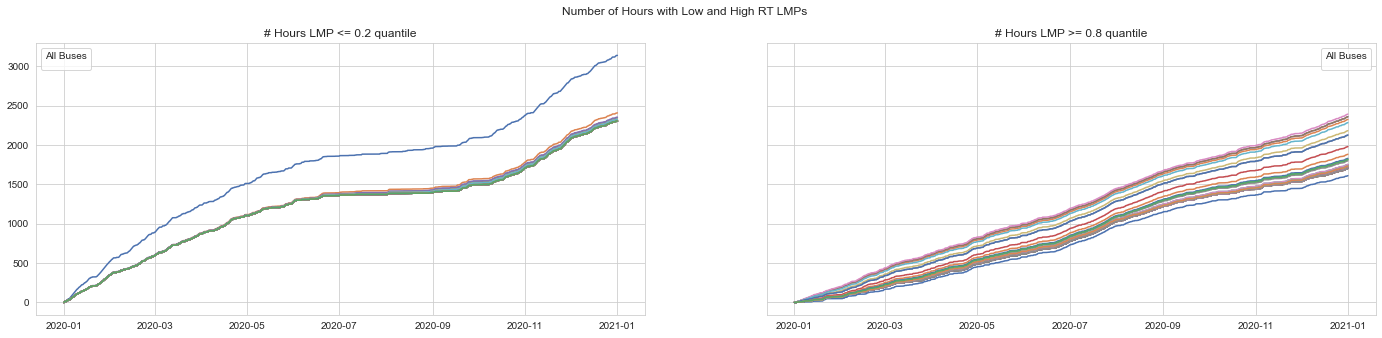

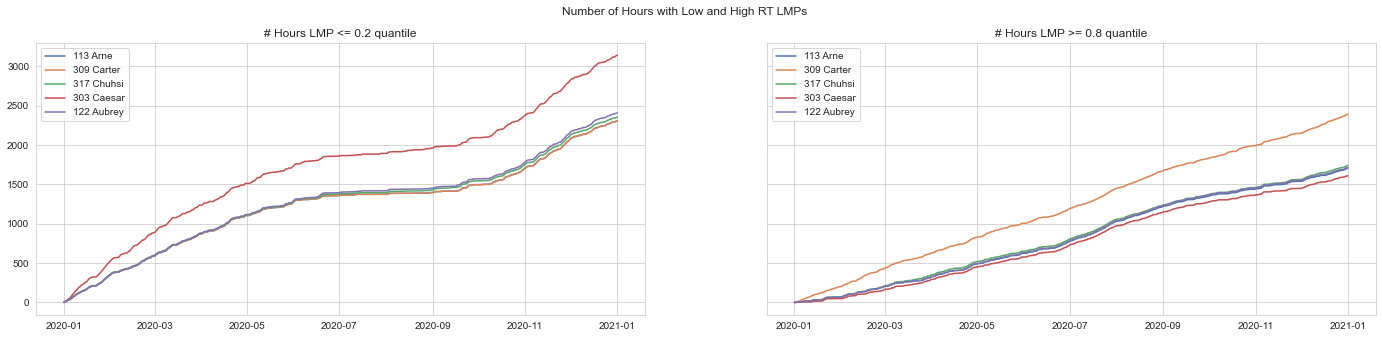

In [3]:
med_lmp, low_lmp, high_lmp = summary["LMP"].quantile(), summary["LMP"].quantile(q=0.20), summary["LMP"].quantile(q=0.80)
print(low_lmp, med_lmp, high_lmp)

fig, ax = plt.subplots(1,2,figsize=(24, 5),sharey=True)

for bus in bus_dict.keys():
    bus_name = bus_dict[int(bus)]
    df_bus = summary[summary['Bus'] == bus_name]["LMP"]

    low_rt_lmp_mask = (df_bus <= low_lmp).astype(float)
    high_rt_lmp_mask = (df_bus >= high_lmp).astype(float)

    ax[0].plot(low_rt_lmp_mask.cumsum())
    ax[1].plot(high_rt_lmp_mask.cumsum())
ax[0].set_title(f"# Hours LMP <= 0.2 quantile")
ax[1].set_title(f"# Hours LMP >= 0.8 quantile")
ax[0].legend(title="All Buses")
ax[1].legend(title="All Buses")
plt.suptitle(f"Number of Hours with Low and High RT LMPs")

fig, ax = plt.subplots(1,2,figsize=(24, 5),sharey=True)

wind_buses = [gen[0:3] for gen in wind_gens]
for bus in [113] + wind_buses:
    bus_name = bus_dict[int(bus)]
    df_bus = summary[summary['Bus'] == bus_name]["LMP"]

    low_rt_lmp_mask = (df_bus <= low_lmp).astype(float)
    high_rt_lmp_mask = (df_bus >= high_lmp).astype(float)

    ax[0].plot(low_rt_lmp_mask.cumsum(), label=f"{bus} {bus_name}")
    ax[1].plot(high_rt_lmp_mask.cumsum(), label=f"{bus} {bus_name}")
ax[0].set_title(f"# Hours LMP <= 0.2 quantile")
ax[1].set_title(f"# Hours LMP >= 0.8 quantile")
ax[0].legend()
ax[1].legend()
plt.suptitle(f"Number of Hours with Low and High RT LMPs")


For LMP hours less than or equal to the 20% quantile value of $0/MWh, computed from LMPs across the entire grid, there are very similar patterns across all buses where there's a lot of low LMP hours in Jan - April and Oct - December, and very few between July and September, except for the Caesar bus which has the very large 303_WIND_1 generator.

LMP hours greater than or equal to the 80% quantile value of $24.62/MWh are more evenly spread throughout the year for all buses, showing a slightly increase in rate during July - August. The rates per bus vary almost uniformly. Comparing just the wind buses, it's clear that Chuhsi, Caesar and Aubrey are on the low end of high-LMP rates, with Caesar being the bus with the lowest cumulative hours of high LMPs, but Carter is the bus with the most high LMP hours.

### LMPs are almost always 0 when there is wind curtailment

Except for 303_WIND_1, which has the most absolute and relative curtailment, the LMPs are 0 when the wind plants are curtailed.

317_WIND_1 is the least curtailed wind plant.

In [4]:
for wind_gen in wind_gens:
    wind_curt = gen_df[gen_df['Generator'] == wind_gen]
    bus_df = summary[summary['Bus'] == bus_dict[int(wind_gen[0:3])]]
    print(wind_gen, "Max LMP during Curtailment:", bus_df[bus_df.index.isin(wind_curt[wind_curt['Curtailment'] > 0].index)]["LMP"].max())

309_WIND_1 Max LMP during Curtailment: -0.0
317_WIND_1 Max LMP during Curtailment: -0.0
303_WIND_1 Max LMP during Curtailment: 5.487908
122_WIND_1 Max LMP during Curtailment: -0.0


Text(0.5, 1.0, 'Ratio of Cumulative Curtailment to Cumulative Output per Wind Generator')

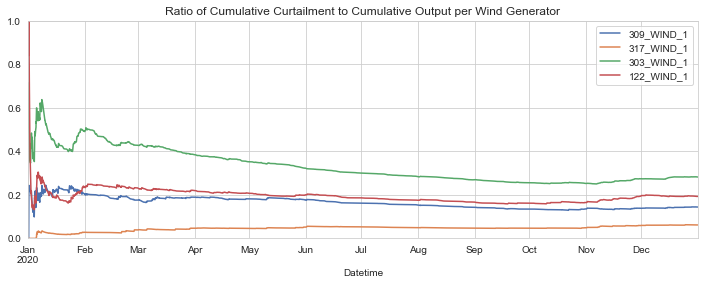

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
for gen in wind_gens:
    df_gen = gen_df[gen_df['Generator'] == gen][['Output', 'Curtailment']].cumsum()
    (df_gen.Curtailment / df_gen.Output).plot(ax=ax, label=gen)
ax.set_ylim(0, 1)
plt.legend()
plt.title("Ratio of Cumulative Curtailment to Cumulative Output per Wind Generator")

### Combining neighboring Wind and CC or CT Plants into a single hybrid plant

Looking at the wind buses and what types are generators are at adjacent buses, 317 Chuhsi and 303 Caesar are the two with neighboring CC or CT plants.

Wind energy can go to the "battery + hydrogen" plant that is at the same node as the gas plant, and see whether the "double loop" dispatch of "hybrid" Wind at Bus A + Battery & Hydrogen at Bus B == the "original" RT dispatch of Wind at Bus A + Gas at Bus B. The bid curve will be same the sum of the wind and gas plant's bid curves.

Whether the curtailment of wind is due to congestion or low demand, by choosing adjacent nodes and moving the NG plants to be at the same bus as the wind, we will make the "baseline" run with this new generator placement.

Can get a feel for congestion by looking at the Relative Overflow of the line or Average LMP Difference between the two buses.

In [40]:
for i in net.edges:
    if i['to'] == '318' and i['from'] == '317':
        print(i["UID"], i["Avg LMP Diff"], "$/MWh average LMP difference")
        break
line_df.query(f"Line == '{i['UID']}'")[["Relative Flow", 'Relative OverFlow']].describe()

C29 0.1469383446038253 $/MWh average LMP difference


,Relative Flow,Relative OverFlow
count,8784.000000,8784.000000
mean,0.397359,0.058451
std,0.301737,0.232827
min,0.000417,0.000000
25%,0.148954,0.000000
50%,0.305656,0.000000
75%,0.628465,0.000000
max,1.000000,1.000000


In [7]:
def get_generators_on_during_high_lmps(summary_df, lmp_lower_bd, plot=True, n_to_plot=None):
    on_when_LMP_high = {}
    for gen in gen_df['Generator'].unique():
        if "CC" in gen or "CT" in gen:
            df_gen = gen_df[gen_df['Generator'] == gen]

            bus = bus_dict[int(gen[0:3])]
            if bus not in summary_df['Bus'].unique():
                continue
            df_bus = summary_df[summary_df['Bus'] == bus]
            not_low_price_lmps = df_bus['LMP'] >= lmp_lower_bd
            on_when_LMP_high[gen] = {
                'dispatched energy' : (not_low_price_lmps * df_gen["Dispatch"].values).values,
                }
            on_when_LMP_high[gen]['dispatched timesteps'] = np.count_nonzero(on_when_LMP_high[gen]['dispatched energy'])
            on_when_LMP_high[gen]['dispatched timesteps ratio'] = on_when_LMP_high[gen]['dispatched timesteps'] / np.count_nonzero(not_low_price_lmps)
            if on_when_LMP_high[gen]['dispatched timesteps ratio'] == 0:
                on_when_LMP_high.pop(gen)

    on_when_LMP_high = {k: v for k, v in sorted(on_when_LMP_high.items(), key=lambda item: -item[1]['dispatched timesteps ratio'])}

    if not plot:
        return on_when_LMP_high

    if n_to_plot is None:
        n_to_plot = len(on_when_LMP_high)

    fig, ax = plt.subplots(1,1,figsize=(24, n_to_plot),sharex=True)
    n = 1
    ylabels = []
    for k, v in on_when_LMP_high.items():
        if n > n_to_plot:
            break
        dispatch_total = [(n_to_plot + 1 - n) if i > 0 else 0 for i in v['dispatched energy']]
        p = ax.scatter(range(len(dispatch_total)), dispatch_total, marker='.', label=k, lw=0.1)
        ylabels.insert(0, k)
        n += 1
    ax.set_ylim((0.5, None))
    ax.set_yticks(range(1, n_to_plot + 1), ylabels)
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
    plt.suptitle(f"Thermal Generators Activity when LMPs > {lmp_lower_bd}")

    fig, ax = plt.subplots(n_to_plot,1,figsize=(24, n_to_plot),sharex=True)
    n = 0
    for k, v in on_when_LMP_high.items():
        if n >= len(ax):
            break
        dispatch_total = (v['dispatched energy'] > 0).astype(float)
        dispatch_total *= gen_df[gen_df['Generator'] == k]['Dispatch'].values
        ax[n].plot(dispatch_total, label=k)
        ax[n].legend(bbox_to_anchor=(1.02,1), loc="upper left")
        n += 1
    
    plt.suptitle(f"Dispatch of CT generators when LMPs > {lmp_lower_bd}")

    return on_when_LMP_high

{'309': ['303_WIND_1', '308_RTPV_1', '312_PV_1'], '317': ['316_STEAM_1', '318_CC_1', '322_HYDRO_1', '322_HYDRO_2', '322_HYDRO_3', '322_HYDRO_4', '322_CT_5', '322_CT_6'], '303': ['301_CT_1', '301_CT_2', '301_CT_3', '301_CT_4', '309_WIND_1', '324_PV_1', '324_PV_2', '324_PV_3'], '122': ['121_NUCLEAR_1']}


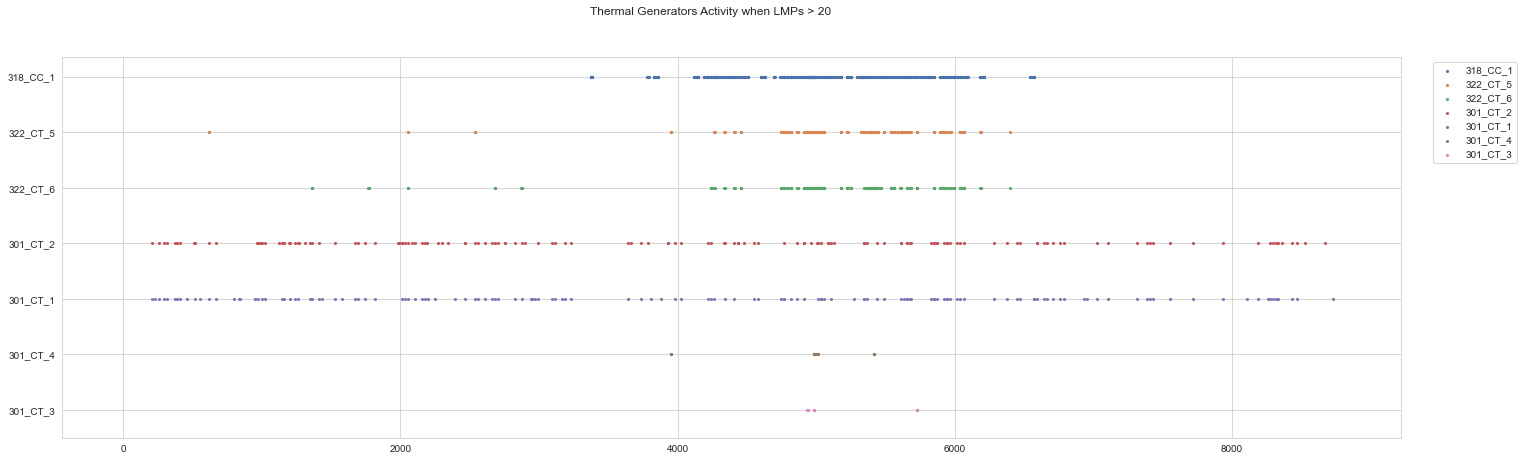

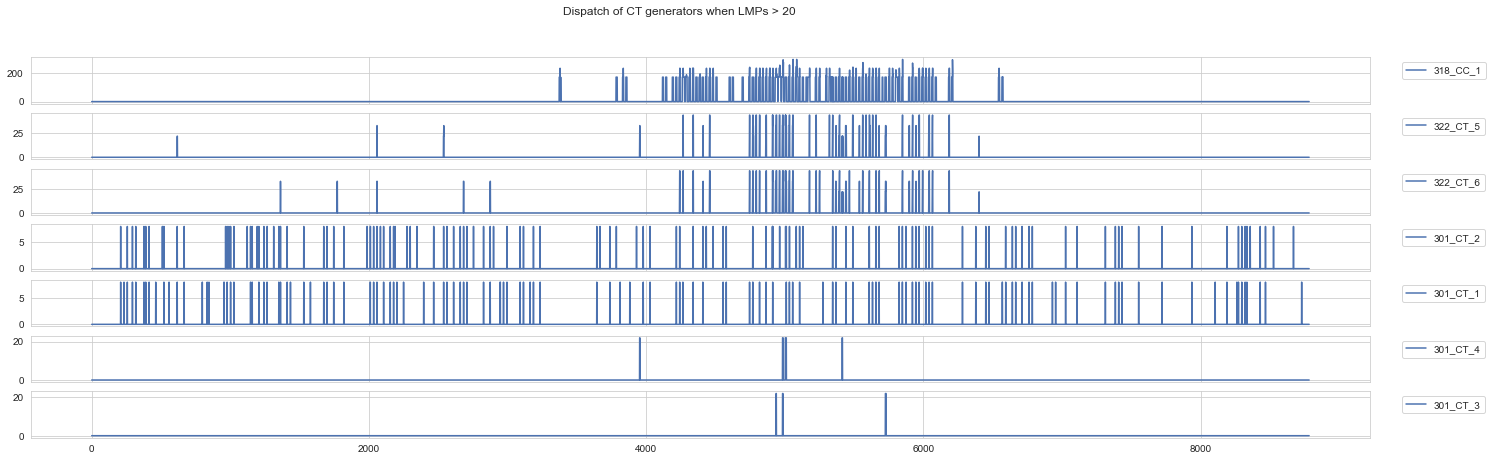

In [8]:
wind_neighbors = {}
for bus in wind_buses:
    wind_neighbors[bus] = []
    for i in nx.neighbors(rts_gmlc_graph, bus):
        wind_neighbors[bus].extend(gen_df[gen_df['Generator'].str.contains(i)]['Generator'].unique())
print(wind_neighbors)

adj_buses = []
for neighbors in wind_neighbors.values():
    adj_buses.extend([int(gen[0:3]) for gen in neighbors])
adj_buses = set(adj_buses)
adj_buses = set(bus_dict[i] for i in adj_buses)

tmp = summary[summary.Bus.isin(adj_buses)].copy()
adj_on_when_LMP_high = get_generators_on_during_high_lmps(tmp, 20, True)

In [9]:
def plot_wind_neighbor_ccct(wind_df):
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    wind_curt = gen_df[gen_df['Generator'] == wind_df][['Curtailment']].cumsum()
    wind_curt.plot(ax=ax, label="Wind Curtailment")

    legend_labels = ["Wind Curtailment"]
    for gen in wind_neighbors[wind_df[0:3]]:
        if "CC" not in gen and "CT" not in gen:
            continue
        legend_labels.append(gen + " Dispatch")
        cc_disp = gen_df[gen_df['Generator'] == gen][['Dispatch']].cumsum()
        cc_disp.plot(ax=ax)
        ax.text(cc_disp.index.values[-1], 
                        cc_disp.values[-1], f' {round((cc_disp.values[-1]/wind_curt.values[-1])[0] * 100)}% of curtailed wind', alpha=0.7)
    ax.legend(legend_labels)
    ax.set_ylabel("Cumulative MWh")
    ax.set_title(f"{wind_df} Curtailment vs Neighbor CC/CT Dispatch")

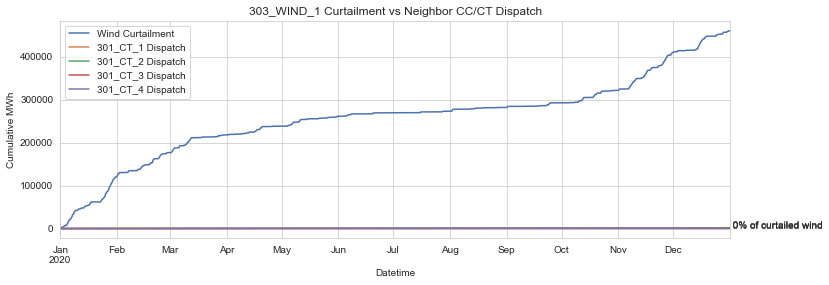

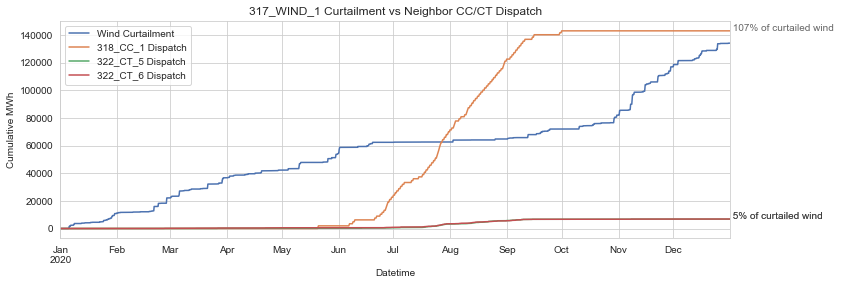

In [10]:
plot_wind_neighbor_ccct('303_WIND_1')
plot_wind_neighbor_ccct('317_WIND_1')

The CT plants next to 303_WIND_1 are doing almost nothing throughout the year, so that's not very interesting.

However, at 317_WIND_1, there are two sets of plants that are possibly interesting to replace: the 318_CC_1 alone and the 322_CT_5 + 322_CT_6 pair. The 318_CC_1 plant is a NG plant with 355 MW Pmax and 170 Pmin, and \$/MWh bid of 3.88 \$/MMBtu * 7.952 MMBtu/MWh = 30.85 \$/MWh.

The 322_CT_5 and 322_CT_6 plants also NG plants both 55 MW Pmax and 22 PMin, and a \$/MWh bid of 3.88 * 12.064 = 46.81 \$/MWh. These are more expensive by fuel cost but are more flexible in terms of run time constraints and start up costs; still they are dispatched less frequently than the cheaper one above. 

The wind curtailment happens at nearly the opposite times as when these NG plants dispatch. The 318_CC_1 plant dispatches 107% of what the wind energy is curtailed, making it impossible to meet that dispatch with the original wind farm + even 100% efficient storage. Instead it would require additional wind capacity in addition to storage. On the other hand, the combined output of the CT plants is 10% of the wind curtailed energy, so even with a 20% efficient hydrogen storage system, it is possible to meet that dispatch, but at what price?

### Potential Pairs of Wind + NG

317_WIND_1 with 318_CC_1 **or** 322_CT_5 or 322_CT_6
 - has less wind curtailment than 303 and 309
 - Line between 317 and 318: C29. 500 MW 
 - Line between 317 and 322: C30. 500 MW

303_WIND_1 with 301_CT[1-4]
 - has a lot of wind curtailment
 - CTs have minimal dispatch
 - Line between 303 and 301: C2. This one has a lot of transmission violations, is a small line 175 MW...

In [11]:
gen = '317_WIND_1'
bus = '317'
bus_name = bus_dict[int(bus)]

wind_lmp_df = gen_df[(gen_df['Generator'] == gen)][["Generator", "Output", "Output DA", 'Unit Market Revenue', 'Unit Cost']]
wind_lmp_df[["LMP", "LMP DA"]] = summary[summary['Bus'] == bus_name][["LMP", "LMP DA"]]
wind_lmp_df = wind_lmp_df[wind_lmp_df["Output"] > 0]

gen = '318_CC_1'
bus = '318'
bus_name = bus_dict[int(bus)]

cc_lmp_df = gen_df[(gen_df['Generator'] == gen)][["Generator", "Dispatch", "Dispatch DA", 'Unit Market Revenue', 'Unit Cost']]
cc_lmp_df[["LMP", "LMP DA"]] = summary[summary['Bus'] == bus_name][["LMP", "LMP DA"]]
cc_lmp_df = cc_lmp_df[cc_lmp_df["Dispatch"] > 0]

wind_cc_df = pd.concat((wind_lmp_df, cc_lmp_df.rename(columns={'Dispatch': "Output", "Dispatch DA": "Output DA"})))

gen = '322_CT_5'
bus = '322'
bus_name = bus_dict[int(bus)]

ct_lmp_df = gen_df[(gen_df['Generator'] == gen)][["Generator", "Dispatch", "Dispatch DA", 'Unit Market Revenue', 'Unit Cost']]
ct_lmp_df[["LMP", "LMP DA"]] = summary[summary['Bus'] == bus_name][["LMP", "LMP DA"]]

gen = '322_CT_6'
ct2_lmp_df = gen_df[(gen_df['Generator'] == gen)]
ct_lmp_df["Dispatch"] += ct2_lmp_df["Dispatch"]
ct_lmp_df["Dispatch DA"] += ct2_lmp_df["Dispatch DA"]
ct_lmp_df["Unit Market Revenue"] += ct2_lmp_df["Unit Market Revenue"]
ct_lmp_df = ct_lmp_df[ct_lmp_df["Dispatch"] > 0]

wind_cc_df = pd.concat((wind_cc_df, ct_lmp_df.rename(columns={'Dispatch': "Output", 'Dispatch DA': "Output DA"})))
wind_cc_df['Revenue per MWh'] = wind_cc_df['Unit Market Revenue'] / wind_cc_df['Output']
wind_cc_df['dLMP'] = wind_cc_df['LMP'] - wind_cc_df['LMP DA']


In [12]:
tmp = summary[summary['Bus'] == bus_dict[318]][["LMP", "LMP DA"]]
tmp[tmp.index == "2020-07-16 14:00:00"]

,LMP,LMP DA
Datetime,,
2020-07-16 14:00:00,126.755559,26.429316


In [13]:
ct_lmp_df[ct_lmp_df["Dispatch"] > 0].sort_values("Unit Market Revenue")

,Generator,Dispatch,Dispatch DA,Unit Market Revenue,Unit Cost,LMP,LMP DA
Datetime,,,,,,,
2020-01-26 16:00:00,322_CT_5,22.000000,22.000000,0.000000,6696.941488,-0.000000,-0.000000
2020-02-26 19:00:00,322_CT_5,22.000000,22.000000,458.258039,0.000000,22.492854,20.829911
2020-01-31 16:00:00,322_CT_5,22.000000,22.000000,508.830168,0.000000,-0.000000,23.128644
2020-04-21 17:00:00,322_CT_5,22.000000,22.000000,515.631757,0.000000,19.034775,23.437807
2020-04-29 18:00:00,322_CT_5,22.000000,22.000000,515.631757,0.000000,23.128644,23.437807
...,...,...,...,...,...,...,...
2020-09-09 17:00:00,322_CT_5,82.112468,97.725286,10603.941667,1501.872309,26.500239,103.482581
2020-09-05 17:00:00,322_CT_5,88.000000,110.000000,11266.213706,1579.882825,26.790897,107.778304
2020-09-23 19:00:00,322_CT_5,44.000000,88.000000,12475.213066,1031.707060,19.983547,126.755559


Text(0.5, 0, 'RT LMP - DA LMP')

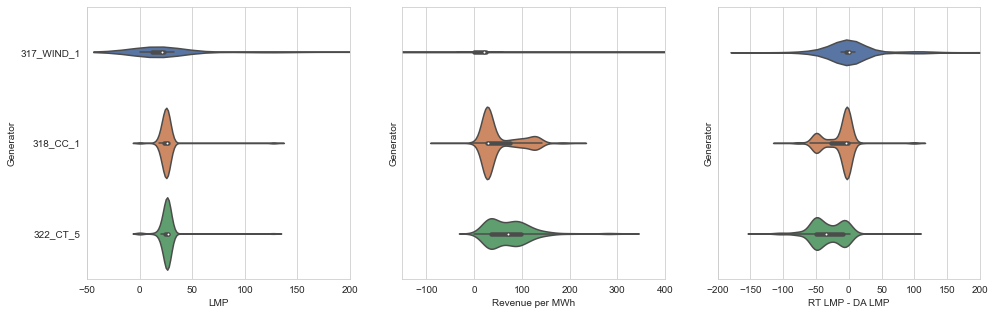

In [14]:
fig, ax = plt.subplots(1,3,figsize=(16, 5),sharey=True)
sns.violinplot(data=wind_cc_df, x='LMP', y='Generator', ax=ax[0])
ax[0].set_xlim(-50, 200)
sns.violinplot(data=wind_cc_df, x='Revenue per MWh', y='Generator', ax=ax[1])
ax[1].set_xlim(-150, 400)
sns.violinplot(data=wind_cc_df, x='dLMP', y='Generator', ax=ax[2])
ax[2].set_xlim(-200, 200)
ax[2].set_xlabel("RT LMP - DA LMP")


In [15]:
cc_on_times = gen_df[gen_df['Generator'] == "318_CC_1"].query("Dispatch > 0").index
clark_df = summary.query(f"Bus == '{bus_dict[318]}'")
display(clark_df[clark_df.index.isin(cc_on_times)][["LMP", "LMP DA"]].sort_values("LMP"))
cc_on_times = clark_df[clark_df.index.isin(cc_on_times)][["LMP", "LMP DA"]].sort_values("LMP").index
cc_df = gen_df[gen_df['Generator'] == "317_WIND_1"]
cc_df[cc_df.index.isin(cc_on_times[0:3])].sort_values("Unit Market Revenue")

,LMP,LMP DA
Datetime,,
2020-09-04 12:00:00,-0.170272,27.893699
2020-08-25 13:00:00,-0.168763,25.824293
2020-08-25 12:00:00,-0.168221,26.898398
2020-08-03 03:00:00,-0.000000,22.516066
2020-08-30 10:00:00,-0.000000,18.861019
...,...,...
2020-06-29 16:00:00,127.274616,26.845129
2020-09-15 18:00:00,127.276799,73.152230
2020-07-30 22:00:00,127.755129,26.842010


,Generator,Output,Output DA,Curtailment,Unit Market Revenue,Unit Uplift Payment,Dispatch,Dispatch DA,Headroom,Unit State,Unit Cost
Datetime,,,,,,,,,,,
2020-09-04 12:00:00,317_WIND_1,330.096386,6.4,66.203614,178.519673,0.0,NaN,NaN,NaN,NaN,NaN
2020-08-25 12:00:00,317_WIND_1,448.814465,735.7,280.985535,17359.801837,0.0,NaN,NaN,NaN,NaN,NaN
2020-08-25 13:00:00,317_WIND_1,500.918908,724.3,218.581092,18704.535715,0.0,NaN,NaN,NaN,NaN,NaN


### Cross-correlations between Time Series about Wind, LMPs and the NG plants

See whether there are significant cross-correlations between the Wind output, curtailment; NG plant outputs; and LMPs

First need to see if these time series are stationary, and if not, take the difference and then compute the cross correlations via both Pearson (linear transformation) and Spearman (rank transformation)

In [16]:
def plot_acfs(arr, title, xlim=200):
    fig, ax = plt.subplots(1,3,figsize=(24, 4), sharex=True)
    pd.plotting.autocorrelation_plot(arr, ax=ax[0])
    pd.plotting.autocorrelation_plot(np.diff(arr), ax=ax[1])
    pd.plotting.autocorrelation_plot(np.diff(np.diff(arr)), ax=ax[2])
    fig.suptitle(title)
    ax[0].set_xlim(0, xlim)

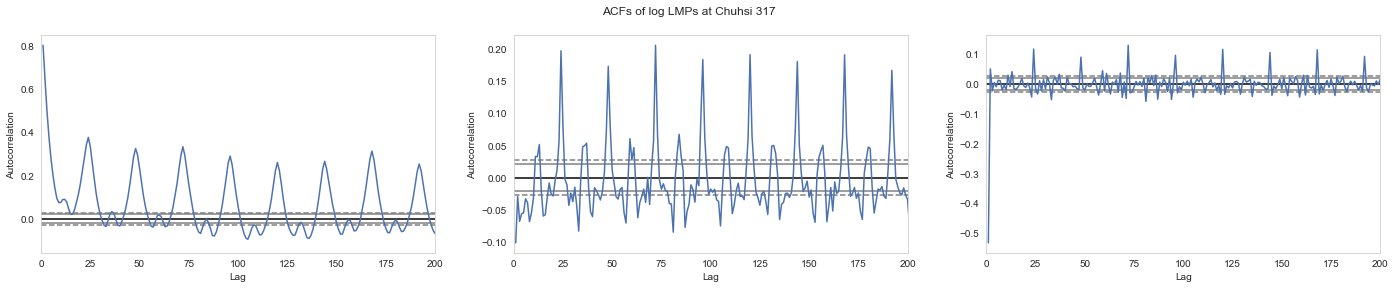

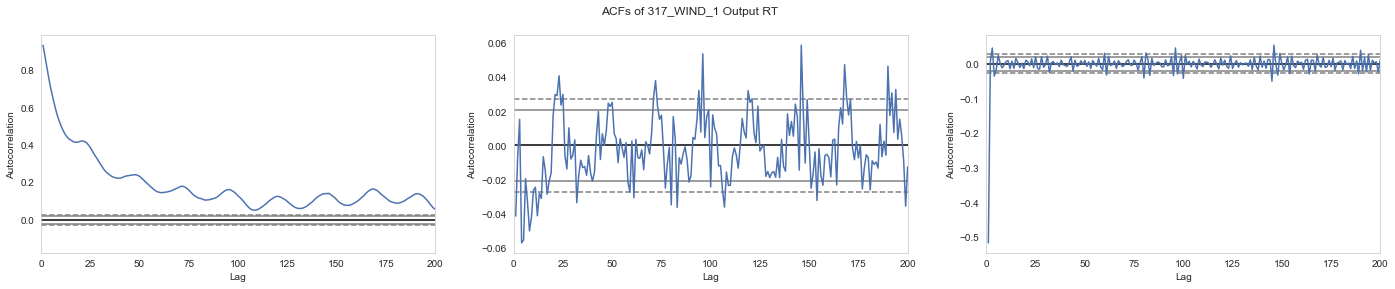

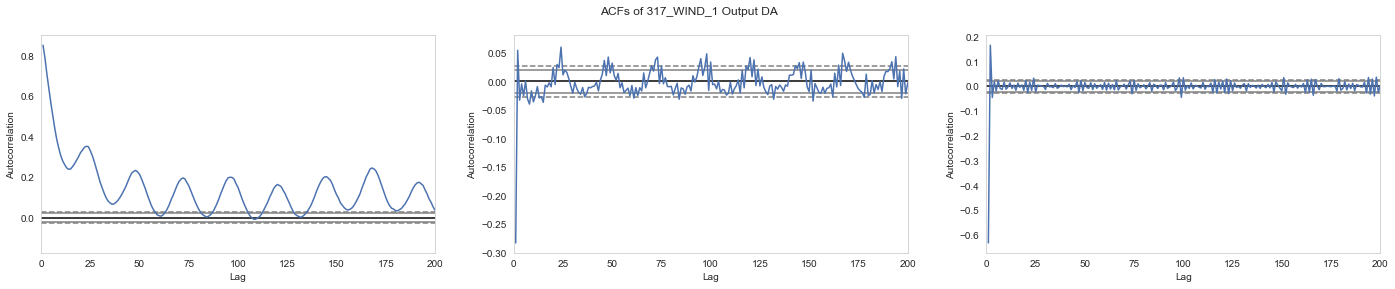

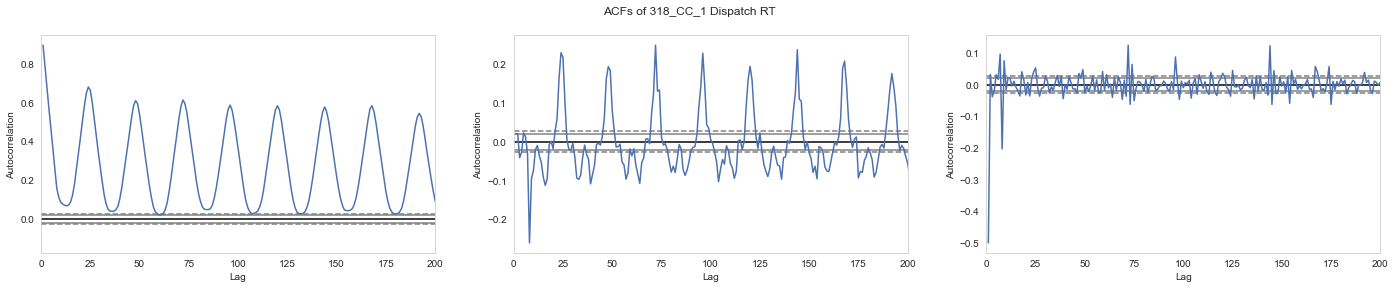

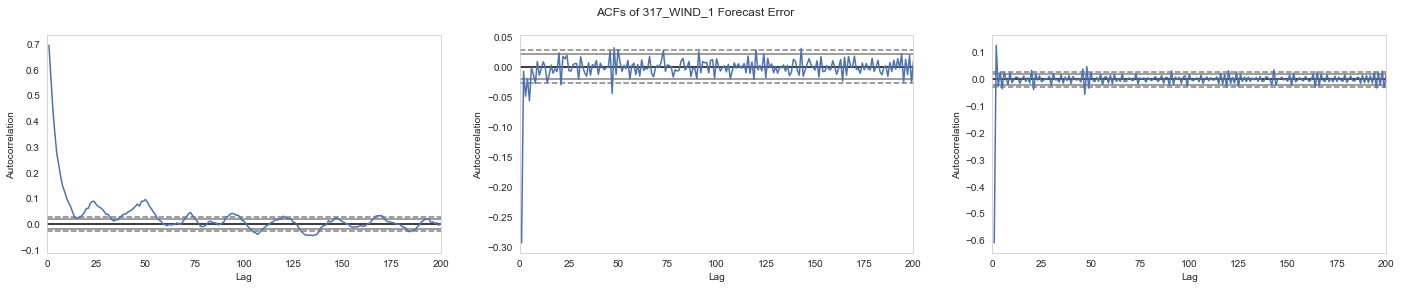

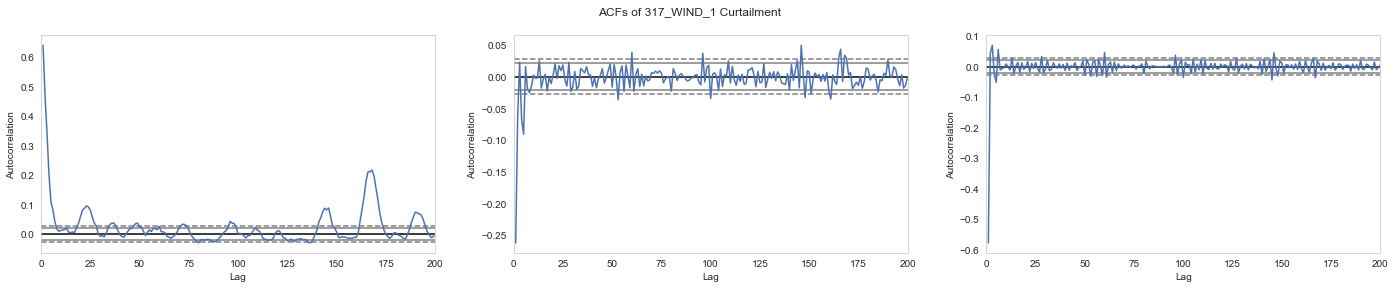

In [17]:
wind_gen = "317_WIND_1"
ng_gen = "318_CC_1"
bus = int(wind_gen[0:3])
bus_name = bus_dict[bus]

lmp = summary[summary['Bus'] == bus_name]["LMP"].values
lmp_log = np.log10(lmp, out=np.zeros_like(lmp), where=lmp!=0)
plot_acfs(lmp_log, f"ACFs of log LMPs at {bus_name} {bus}")

wind = gen_df[gen_df['Generator'] == wind_gen]["Output"].values
plot_acfs(wind, f"ACFs of {wind_gen} Output RT")

wind_da = gen_df[gen_df['Generator'] == wind_gen]["Output DA"].values
plot_acfs(wind_da, f"ACFs of {wind_gen} Output DA")

cc = gen_df[gen_df['Generator'] == ng_gen]["Dispatch"].values
plot_acfs(cc, f"ACFs of {ng_gen} Dispatch RT")

wind_err = wind - wind_da
plot_acfs(wind_err, f"ACFs of {wind_gen} Forecast Error")

wind_curt = gen_df[gen_df['Generator'] == wind_gen]["Curtailment"].values
plot_acfs(wind_curt, f"ACFs of {wind_gen} Curtailment")

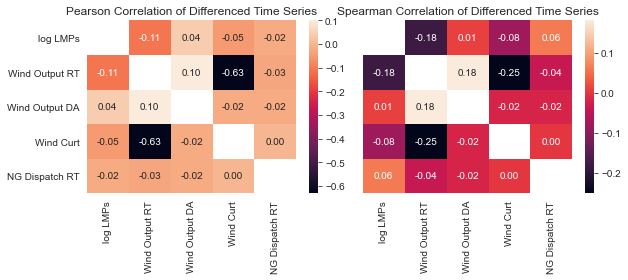

In [18]:
from scipy.stats import pearsonr, spearmanr

corr_vals = [lmp_log, wind, wind_da, wind_curt, cc]
corr_labels = ["log LMPs", "Wind Output RT", "Wind Output DA", 'Wind Curt', "NG Dispatch RT"]

fig, ax = plt.subplots(1,2,figsize=(9, 4), sharey=True)

pearson_diff_df = pd.DataFrame(columns=corr_labels, index=corr_labels)
spearman_diff_df = pd.DataFrame(columns=corr_labels, index=corr_labels)

for val, label in zip(corr_vals, corr_labels):
    pearson_diff_df[label] = [round(pearsonr(np.diff(val), np.diff(v))[0], 2) for v in corr_vals]
    spearman_diff_df[label] = [round(spearmanr(np.diff(val), np.diff(v))[0], 2) for v in corr_vals]

pearson_diff_df.replace(1, np.nan, inplace=True)
spearman_diff_df.replace(1, np.nan, inplace=True)

sns.heatmap(pearson_diff_df, annot=True, fmt=".2f", ax=ax[0])
ax[0].set_title("Pearson Correlation of Differenced Time Series")
sns.heatmap(spearman_diff_df, annot=True, fmt=".2f", ax=ax[1])
ax[1].set_title("Spearman Correlation of Differenced Time Series")
plt.tight_layout()

After adjusting for autocorrelation, the cross-correlations are a bit small, but the ones that do stand out are:

 - the negative correlations between Wind Output RT and log LMPs
 - the negative correlations between Wind Output RT and Wind Curt
 - smaller negative correlation between Wind Curt and log LMPs
 - small postive correlation between NG Dispatch RT and log LMPs

In [41]:
df_energy = pd.DataFrame(columns=["Reserves", 'Shortfall Price', "317_WIND Output", "317_WIND Curt", '322_CT Gen Load', "322_CT Load to Curt", "318_CC Gen Load", '318_CC Load to Curt'])

df_energy_timeseries = []

for rts_gmlc_dir in rts_gmlc_dirs:
    summary, gen_df = read_prescient_outputs(rts_gmlc_dir, rts_gmlc.source_data_path)
    
    wind_df = gen_df.query('Generator == "317_WIND_1"')['Output']
    wind_curt_df = gen_df.query('Generator == "317_WIND_1"')['Curtailment']
    cc_df = gen_df.query('Generator == "322_CT_5"')['Dispatch'] + gen_df.query('Generator == "322_CT_6"')['Dispatch']
    cc_df_2 = gen_df.query('Generator == "318_CC_1"')['Dispatch']

    reserves = int(rts_gmlc_dir.stem.split('_w_')[1].split('_')[0]) if 'reserves' in rts_gmlc_dir.stem else 0
    shortfall = int(rts_gmlc_dir.stem.split('reserves_')[1].split('_')[0]) if 'shortfall' in rts_gmlc_dir.stem else 10000

    wind_cf = read_rts_gmlc_wind_inputs_with_fix(rts_gmlc.source_data_path, gen_df)

    df_energy_ts = pd.DataFrame(index=wind_df.index)
    df_energy_ts['317_WIND Output'] = wind_df
    df_energy_ts['317_WIND Curtail'] = wind_curt_df
    df_energy_ts['322_CT Output'] = cc_df
    df_energy_ts['318_CC Output'] = cc_df_2
    df_energy_ts['Reserves'] = reserves
    df_energy_ts['Shortfall'] = shortfall
    df_energy_ts['317_WIND_1-RTCF'] = wind_cf['317_WIND_1-RTCF']
    df_energy_timeseries.append(df_energy_ts)

    df_energy.loc[len(df_energy)] = [reserves, shortfall, wind_df.sum(), wind_curt_df.sum(), cc_df.sum(), cc_df.sum() / wind_curt_df.sum(), cc_df_2.sum(), cc_df_2.sum() / wind_curt_df.sum()]

df_energy_timeseries = pd.concat(df_energy_timeseries)
# df_energy_timeseries.to_csv("data/Wind_Thermal_Gen.csv")
df_energy

,Reserves,Shortfall Price,317_WIND Output,317_WIND Curt,322_CT Gen Load,322_CT Load to Curt,318_CC Gen Load,318_CC Load to Curt
0,10.0,1000.0,2.167995e+06,134045.296606,13674.542393,0.102014,142953.341462,1.066455
1,10.0,500.0,2.156710e+06,145330.114503,13034.693244,0.089690,138837.636813,0.955326
2,15.0,1000.0,2.146841e+06,155199.622871,18697.216549,0.120472,151559.832609,0.976548
3,15.0,500.0,2.134030e+06,168010.514560,18703.066668,0.111321,160638.694980,0.956123


Across the 4 prescient runs, the 317_WIND, 322_CT and 318_CC outputs are pretty similar. The wind curtailment increases with reserves and decreases with shortfall price. The ratio of 318_CC to Wind Curtailment is higher with higher shortfall price and not changed much by reserve level. The ratio of 322_CT to Wind Curtailment is higher with higher reserve levels and higher shortfall prices.

Looking at higher reserves and lower shortfall price seems most interesting


# Modified Generators

In [44]:
rts_gmlc_mod_dirs = [
    # Path("/Users/dguittet/Projects/Dispatches/workspace/prescient_runs/simulate_with_network_with_uncertainty_w_10_reserves_achp_317_CC"),
    Path("/Users/dguittet/Projects/Dispatches/workspace/prescient_runs/simulate_with_network_with_uncertainty_w_10_reserves_317_CC"),
    Path("/Users/dguittet/Projects/Dispatches/workspace/prescient_runs/simulate_with_network_with_uncertainty_w_10_reserves_317_CT"),
    Path("/Users/dguittet/Projects/Dispatches/workspace/prescient_runs/simulate_with_network_with_uncertainty_w_15_reserves_500_shortfall_317_CT"),
    Path("/Users/dguittet/Projects/Dispatches/workspace/prescient_runs/simulate_with_network_with_uncertainty_w_15_reserves_500_shortfall_317_CC"),
]
df_energy_mod = pd.DataFrame(columns=["Mod Gen", "Reserves", 'Shortfall Price', "317_WIND Output", "317_WIND Curt", '317_CC/T Gas Load', "317_CC/T Load to Curt"])

df_energy_mod_timeseries = []

for rts_gmlc_dir in rts_gmlc_mod_dirs:
    mod_gas_gen = str(rts_gmlc_dir)[-6:]
    rts_gmlc_mod_source = Path(f"/Users/dguittet/Projects/Dispatches/Prescient/downloads/rts_gmlc/RTS-GMLC/RTS_Data/SourceData_{mod_gas_gen}")

    summary, gen_df = read_prescient_outputs(rts_gmlc_dir, rts_gmlc_mod_source)
    
    wind_df = gen_df.query('Generator == "317_WIND_1"')['Output']
    wind_curt_df = gen_df.query('Generator == "317_WIND_1"')['Curtailment']
    if 'CT' in mod_gas_gen:
        cc_df = gen_df.query('Generator == "317_CT_5"')['Dispatch'] + gen_df.query('Generator == "317_CT_6"')['Dispatch']
    elif 'CC' in mod_gas_gen:
        cc_df = gen_df.query(f'Generator == "317_CC_1"')['Dispatch']

    reserves = int(rts_gmlc_dir.stem.split('_w_')[1].split('_')[0]) if 'reserves' in rts_gmlc_dir.stem else 0
    shortfall = int(rts_gmlc_dir.stem.split('reserves_')[1].split('_')[0]) if 'shortfall' in rts_gmlc_dir.stem else 10000

    wind_cf = read_rts_gmlc_wind_inputs_with_fix(rts_gmlc_mod_source, gen_df)

    df_energy_ts = pd.DataFrame(index=wind_df.index)
    df_energy_ts['317_WIND Output'] = wind_df
    df_energy_ts['317_WIND Curtail'] = wind_curt_df
    df_energy_ts['Gas Output'] = cc_df
    df_energy_ts['Mod Gen'] = mod_gas_gen
    df_energy_ts['Reserves'] = reserves
    df_energy_ts['Shortfall'] = shortfall
    df_energy_ts['317_WIND_1-RTCF'] = wind_cf['317_WIND_1-RTCF']
    df_energy_mod_timeseries.append(df_energy_ts)

    df_energy_mod.loc[len(df_energy_mod)] = [mod_gas_gen, reserves, shortfall, wind_df.sum(), wind_curt_df.sum(), cc_df.sum(), cc_df.sum() / wind_curt_df.sum()]

df_energy_mod_timeseries = pd.concat(df_energy_mod_timeseries)
df_energy_mod_timeseries.to_csv("data/Wind_Thermal_Gen.csv")
df_energy_mod.query("Reserves == 15.0")

,Mod Gen,Reserves,Shortfall Price,317_WIND Output,317_WIND Curt,317_CC/T Gas Load,317_CC/T Load to Curt
0,317_CC,10,10000,2.169660e+06,132380.388203,141002.358947,1.065130
1,317_CT,10,10000,2.167364e+06,134676.603410,13074.845711,0.097083
2,317_CT,15,500,2.144621e+06,157418.920908,18958.224915,0.120432
3,317_CC,15,500,2.142653e+06,159387.189972,161293.729574,1.011962


In [48]:
df_energy.query("Reserves == 15.0")

,Reserves,Shortfall Price,317_WIND Output,317_WIND Curt,322_CT Gen Load,322_CT Load to Curt,318_CC Gen Load,318_CC Load to Curt
2,15.0,1000.0,2.146841e+06,155199.622871,18697.216549,0.120472,151559.832609,0.976548
3,15.0,500.0,2.134030e+06,168010.514560,18703.066668,0.111321,160638.694980,0.956123


For the 15% reserve and 500 \$/MWh shortfall price, once the NG generators have been moved to the wind bus, the wind curtailment increases by 5.4% while the NG plant dispatches are nearly the same. The 318_CC load to wind curtailment ratio has decreased by 5.6% and the 322_CT ratio has decreased by 1%.

## Conceptual Design Optimization for the Wind + Battery + Hydrogen Plant

After selecting a pair of wind and gas plants, want to design a wind + battery + hydrogen IES that can emulate the combined dispatch of the two original plants, and this IES will bid as the sum of the separate original plants.

It'll be interesting to see what clues may be revealed as to how the IES can do better than as just "the sum of its parts"
